# Handwritten Character Recognition (College Project)

## Import Required Packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import cv2 as cv
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.svm import SVC
import xgboost as xgb
from keras.layers import Dense,BatchNormalization,Dropout,Conv2D,MaxPooling2D,Flatten,GlobalMaxPool2D
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential

Using TensorFlow backend.


### Change DIR to the data folder. This dataset has been prepared by me and my teammates.

In [2]:
%cd /kaggle/input/english-alphabets/english_alphabets


/kaggle/input/english-alphabets/english_alphabets


### Now, Lets read all the images and store them as a big list.
    Directory Structure:
    
    [English_alphabets]
                |
                |____[A]
                |    |
                |    |__1765.jpg
                |    |__1764.jpg
                |
                |
                |____[B]
                |
                |
                |____[Z]

In [3]:
alphabets = os.listdir('/kaggle/input/english-alphabets/english_alphabets')
main_list = []
for i in range(len(alphabets)):
    sub_list=[]
    os.chdir('/kaggle/input/english-alphabets/english_alphabets/{}'.format(alphabets[i]))
    imgs = os.listdir()
    for j in imgs:
        img = cv.imread(j,-1).flatten()
        sub_list.append([img,alphabets[i]])
    main_list.append(sub_list)

### DataFrame creation for easy processing and modelling.

In [4]:
df_main_list = []
for i in range(26):
    df = pd.DataFrame(main_list[i])
    df_main_list.append(df)
df = pd.concat(df_main_list,axis=0,ignore_index=True)
df = pd.concat([df[0].apply(pd.Series),df[1]],axis=1,ignore_index=True) # Explode the lists
# shuffle all the  rows
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156
0,0,0,4,7,4,9,11,0,0,15,...,0,0,0,0,0,0,0,0,0,A
1,0,0,4,0,7,0,13,6,0,0,...,0,0,0,0,0,0,0,0,0,M
2,2,0,5,1,0,9,1,0,0,1,...,0,0,0,0,0,0,0,0,0,P
3,5,0,0,2,135,192,10,0,0,8,...,217,250,61,0,7,10,5,0,0,K
4,0,11,0,0,22,0,7,0,9,0,...,0,0,87,188,194,41,6,0,0,G


### Split Train and test sets.

In [6]:
Y = df.pop(1156)
x_train,x_test,y_train,y_test = train_test_split(df,Y,test_size=0.3,stratify=Y)

### Let's plot some alphabets to get the general idea.

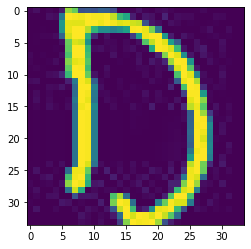

In [7]:
 def show(image):
    """
    Pass the index number of the row/datapoint to view its plot
    """
    a = x_train.iloc[image].values.reshape(34,34)
    plt.imshow(a)
    plt.show()
show(120)

# Exploratory Data Analysis

In [8]:
# Get basic info about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 1156 entries, 0 to 1155
dtypes: uint8(1156)
memory usage: 7.5 MB


In [9]:
# number of datapoints available for each class
Y.value_counts()

A    391
N    350
P    336
C    297
O    292
F    284
L    282
D    274
X    272
B    272
S    263
M    261
Q    251
G    250
E    249
V    244
Z    240
R    239
U    237
W    237
H    229
J    227
T    226
K    217
Y    210
I    201
Name: 1156, dtype: int64

In [10]:
# Check whether there are any null/missing values.
print(f"The number of Null values in the dataframe : {df.isna().values.flatten().sum()}")

The number of Null values in the dataframe : 0


### Visualization using PCA and T-SNE

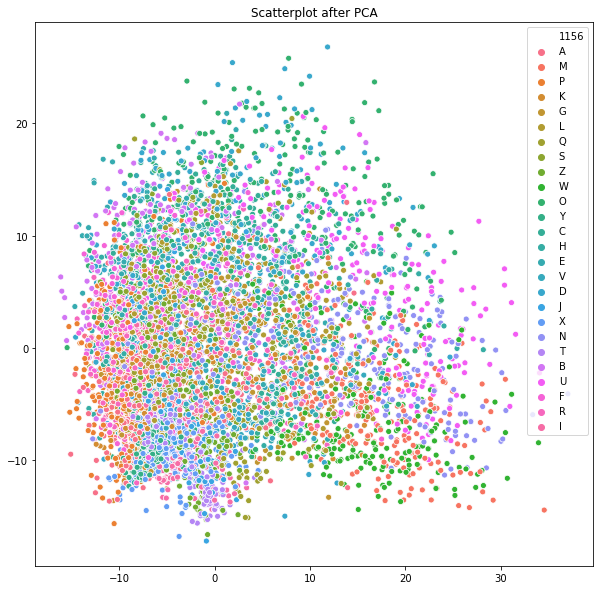

In [11]:
X = StandardScaler().fit_transform(df)
pca = PCA(n_components=2)
visual_data = pca.fit_transform(X)
plt.figure(figsize=(10,10))
sns.scatterplot(visual_data[:,0],visual_data[:,1],hue=Y)
plt.title("Scatterplot after PCA")
plt.show()

> Dosen't give us much to interpret

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 6831 samples in 1.116s...
[t-SNE] Computed neighbors for 6831 samples in 123.355s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6831
[t-SNE] Computed conditional probabilities for sample 2000 / 6831
[t-SNE] Computed conditional probabilities for sample 3000 / 6831
[t-SNE] Computed conditional probabilities for sample 4000 / 6831
[t-SNE] Computed conditional probabilities for sample 5000 / 6831
[t-SNE] Computed conditional probabilities for sample 6000 / 6831
[t-SNE] Computed conditional probabilities for sample 6831 / 6831
[t-SNE] Mean sigma: 6.948788
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.317856
[t-SNE] KL divergence after 1000 iterations: 1.750586


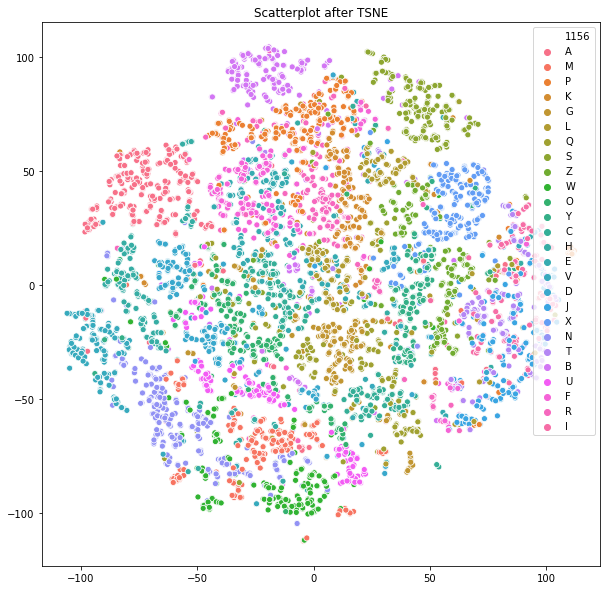

In [12]:
tsne = TSNE(n_components=2,perplexity=5,verbose=1)
visual_data = tsne.fit_transform(X)
plt.figure(figsize=(10,10))
sns.scatterplot(visual_data[:,0],visual_data[:,1],hue=Y)
plt.title("Scatterplot after TSNE")
plt.show()

> This plot gives us a little clearer picture of the dataset, This is a lot better than PCA.

# Modeling using various ML techniques

## SVM

In [13]:
svm_pipe = make_pipeline(StandardScaler(),SVC())
svm_pipe.fit(x_train,y_train)
y_pred = svm_pipe.predict(x_test)
print(f"ACCURACY : {accuracy_score(y_test,y_pred)}")

ACCURACY : 0.9034146341463415


## Logistic regression

In [14]:
lr_pipe = make_pipeline(StandardScaler(),LogisticRegression(max_iter=1000))
lr_pipe.fit(x_train,y_train)
y_pred = lr_pipe.predict(x_test)
print(f"ACCURACY : {accuracy_score(y_test,y_pred)}")

ACCURACY : 0.811219512195122


In [15]:
xgb_pipe = make_pipeline(StandardScaler(),xgb.XGBClassifier())
xgb_pipe.fit(x_train,y_train)
y_pred = xgb_pipe.predict(x_test)
print(f"ACCURACY : {accuracy_score(y_test,y_pred)}")

ACCURACY : 0.824390243902439


In [16]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
model = Sequential()
model.add(Dense(1024,input_shape=(1156,),activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(26,activation='softmax'))
                
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

history = model.fit(x_train,y_train,epochs=25,batch_size=512,validation_split=0.1)



Train on 4302 samples, validate on 479 samples
Epoch 1/25
4302/4302 [==============================] - 2s 384us/step - loss: 3.0406 - accuracy: 0.2280 - val_loss: 1.7967 - val_accuracy: 0.4906
Epoch 2/25
4302/4302 [==============================] - 1s 146us/step - loss: 1.7400 - accuracy: 0.5163 - val_loss: 1.3212 - val_accuracy: 0.6618
Epoch 3/25
4302/4302 [==============================] - 1s 150us/step - loss: 1.3348 - accuracy: 0.6413 - val_loss: 1.0842 - val_accuracy: 0.6931
Epoch 4/25
4302/4302 [==============================] - 1s 144us/step - loss: 1.1318 - accuracy: 0.7060 - val_loss: 0.9083 - val_accuracy: 0.7516
Epoch 5/25
4302/4302 [==============================] - 1s 149us/step - loss: 0.9694 - accuracy: 0.7543 - val_loss: 0.8187 - val_accuracy: 0.7683
Epoch 6/25
4302/4302 [==============================] - 1s 150us/step - loss: 0.8592 - accuracy: 0.7845 - val_loss: 0.7298 - val_accuracy: 0.7912
Epoch 7/25
4302/4302 [==============================] - 1s 147us/step - loss:

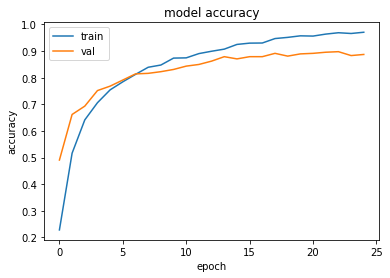

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
model.evaluate(x_test,y_test,batch_size=512,verbose=1)

2050/2050 [==============================] - 0s 42us/step


[0.39381710204091375, 0.9009755849838257]

## CNN

Found 5475 images belonging to 26 classes.
Found 1356 images belonging to 26 classes.
Epoch 1/15
172/172 [==============================] - 10s 55ms/step - loss: 3.3853 - accuracy: 0.0563 - val_loss: 3.2158 - val_accuracy: 0.0516
Epoch 2/15
172/172 [==============================] - 9s 52ms/step - loss: 3.0747 - accuracy: 0.1121 - val_loss: 3.0556 - val_accuracy: 0.0929
Epoch 3/15
172/172 [==============================] - 9s 52ms/step - loss: 2.8778 - accuracy: 0.1472 - val_loss: 2.9578 - val_accuracy: 0.1195
Epoch 4/15
172/172 [==============================] - 9s 53ms/step - loss: 2.7035 - accuracy: 0.1881 - val_loss: 2.5952 - val_accuracy: 0.1571
Epoch 5/15
172/172 [==============================] - 9s 51ms/step - loss: 2.5526 - accuracy: 0.2259 - val_loss: 2.1723 - val_accuracy: 0.2596
Epoch 6/15
172/172 [==============================] - 9s 52ms/step - loss: 2.4503 - accuracy: 0.2524 - val_loss: 2.8500 - val_accuracy: 0.2279
Epoch 7/15
172/172 [==============================] - 9

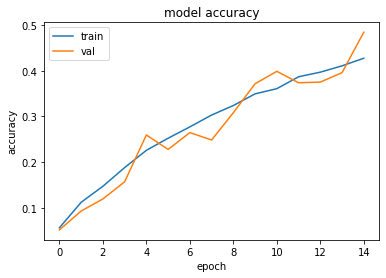

In [19]:
train_data_dir = '/kaggle/input/english-alphabets/english_alphabets/'
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(34,34),
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(34,34),
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

# Define Model

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(34,34,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3),activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalMaxPool2D())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(26,activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    validation_data = validation_generator, 
    epochs = 15)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()